# Imports


In [1]:
import numpy as np
import os
import glob
import cv2
import seaborn as sns
import pandas as pd

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To unzip
import tarfile

# Preparing data

In [2]:

url = "./input/classificatie.tar"
destinationpath = os.path.join("input")

def fetch_import_data(musti_input = url, destiation = destinationpath):
  if not os.path.isdir(destiation):
    os.makedirs(destiation)
  
  tgz_path = os.path.join(destiation, "classificatie.tar")
  input_tgz = tarfile.open(tgz_path)
  input_tgz.extractall(path=destiation)
  input_tgz.close()


In [3]:
im = []
X = []
y = []

inside = os.path.join("input", "classificatie", "aanwezig")
outside = os.path.join("input", "classificatie", "buiten")
nothing = os.path.join("input", "classificatie", "niets")

images = glob.glob(f"{inside}/*")

for i in images:
    img = cv2.imread(i)
    im.append(img)
    img = cv2.resize(img, (64,32))

    x = 1 - cv2.split(img)[0] / 255.0
    x = np.array(x).ravel().reshape(32, 64)
    X.append(x)
    y.append(0)

images = glob.glob(f"{outside}/*")

for i in images:
    img = cv2.imread(i)
    im.append(img)
    img = cv2.resize(img, (64,32))

    x = 1 - cv2.split(img)[0] / 255.0
    x = np.array(x).ravel().reshape(32, 64)
    X.append(x)
    y.append(1)

images = glob.glob(f"{nothing}/*")

for i in images:
    img = cv2.imread(i)
    im.append(img)
    img = cv2.resize(img, (64,32))

    x = 1 - cv2.split(img)[0] / 255.0
    x = np.array(x).ravel().reshape(32, 64)
    X.append(x)
    y.append(2)



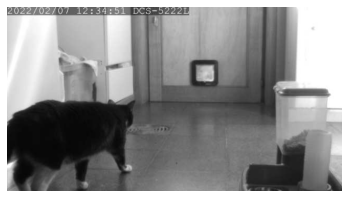

In [4]:
some_inside_image = im[0]
plt.imshow(some_inside_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

Check if there are images and labels in the arrays

In [5]:
y[0]

0

Creating trainings-, test and validatiotingsets

In [6]:
from sklearn.model_selection import train_test_split

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42) 

Number of records in X_train and X_test

In [8]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of X_val: {X_valid.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_val: {y_valid.shape}")

Shape of X_train: (1683, 32, 64)
Shape of X_test: (660, 32, 64)
Shape of X_val: (297, 32, 64)
Shape of y_train: (1683,)
Shape of y_test: (660,)
Shape of y_val: (297,)


# Convolutional Neural Network


## Standardize data

In [9]:
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

In [10]:
import tensorflow as tf
from tensorflow import keras
from functools import partial

# Zelf toegevoegd
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential()
model.add(DefaultConv2D(filters=64, kernel_size=7, input_shape=[32, 64, 1]))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(DefaultConv2D(filters=128))
model.add(DefaultConv2D(filters=128))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(DefaultConv2D(filters=256))
model.add(DefaultConv2D(filters=256))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(150, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(3, activation="softmax"))

# model = keras.models.Sequential()
# model.add(keras.layers.Conv2D(filters = 96, input_shape = [32, 64, 1], kernel_size = 11, strides = 4, padding = 'valid', activation="relu"))
# model.add(keras.layers.MaxPooling2D(pool_size = 2, strides = 2, padding = 'valid'))
# model.add(keras.layers.Conv2D(filters = 256, kernel_size = 11, strides = 1, padding = 'valid', activation="relu"))
# model.add(keras.layers.MaxPooling2D(pool_size = 2, strides = 2, padding = 'valid'))
# model.add(keras.layers.Conv2D(filters = 384, kernel_size = 3, strides = 1, padding = 'valid', activation="relu"))
# model.add(keras.layers.Conv2D(filters = 384, kernel_size = 3, strides = 1, padding = 'valid', activation="relu"))
# model.add(keras.layers.Conv2D(filters = 256, kernel_size = 3, strides = 1, padding = 'valid', activation="relu"))
# model.add(keras.layers.MaxPooling2D(pool_size = 2, strides = 2, padding = 'valid'))
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(4096, activation="relu"))
# model.add(keras.layers.Dropout(0.4))
# model.add(keras.layers.Dense(4096, activation="relu"))
# model.add(keras.layers.Dropout(0.4))
# model.add(keras.layers.Dense(3, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

## LeNet-5

In [11]:
import tensorflow as tf
from tensorflow import keras

# Zelf toegevoegd
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

lenet = keras.Sequential()

lenet.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=[32,64,1]))
lenet.add(keras.layers.MaxPooling2D())

lenet.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
lenet.add(keras.layers.MaxPooling2D())

lenet.add(keras.layers.Flatten())

lenet.add(keras.layers.Dense(units=120, activation='relu'))

lenet.add(keras.layers.Dense(units=84, activation='relu'))

lenet.add(keras.layers.Dense(units=10, activation = 'softmax'))

lenet.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### Making sure we get the best model

In [12]:
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=2, mode='auto',
    baseline=None, restore_best_weights=True)
callback = [keras.callbacks.ModelCheckpoint(
  filepath="CNN.h5",
  save_best_only=True,
  monitor="val_loss")
]

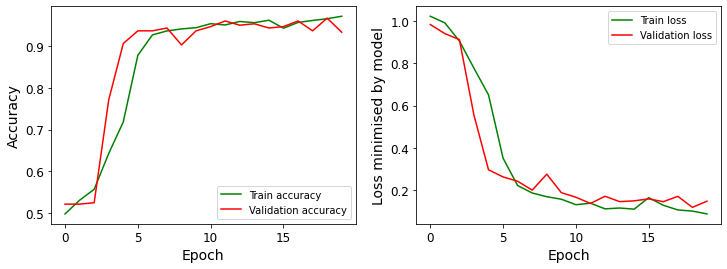

In [13]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), verbose=0, callbacks=callback)

plot_history(history)

## Testen op testset


In [14]:
test_model = keras.models.load_model("CNN.h5")
y_pred = model.predict(X_test).argmax(axis=1)
correct = 0
for i, _ in enumerate(y_pred):
    if y_pred[i] == y_test[i]:
        correct+=1

print("Test acc:", correct/len(y_pred))

Test acc: 0.943939393939394
